#### This Notebook is for analyzing uncertainty of SpeCollate embeddings

In [1]:
model_path = "" ## Specify your model weights here


### Install dependencies
# !pip install scikit-learn
# !git  clone https://github.com/jasonlaska/spherecluster.git
# !pip install ipywidgets
# !pip install tqdm
# !pip install matplotlib
# !pip install spherecluster


In [2]:
import ast
import os
import pickle
import re
from collections import OrderedDict
from configparser import ConfigParser
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from scipy.special import iv, logsumexp
from spherecluster import VonMisesFisherMixture
from sklearn.neighbors import NearestNeighbors


import sys

sys.path.append("./")
sys.path.append("./src")
from src.snapconfig import config
config.PARAM_PATH = "./config.ini"

import run_train as main
from src.snaptrain import dataset, trainmodel

from src.snaputils import simulatespectra as sim

In [3]:
# Temporary config func. Original one in the project.
class config:
    """Define constants"""

    AAMass = OrderedDict(
        [
            ("A", 71.037114),
            ("C", 103.009185),
            ("D", 115.026943),
            ("E", 129.042593),
            ("F", 147.068414),
            ("G", 57.021464),
            ("H", 137.058912),
            ("I", 113.084064),
            ("K", 128.094963),
            ("L", 113.084064),
            ("M", 131.040485),
            ("N", 114.042927),
            ("P", 97.052764),
            ("Q", 128.058578),
            ("R", 156.101111),
            ("S", 87.032028),
            ("T", 101.047679),
            ("V", 99.068414),
            ("W", 186.079313),
            ("Y", 163.0633),
            ("p", 79.9663),
            ("o", 15.994915),
            ("h", 0.9840),
            ("c", 57.02146),
            ("a", 42.0106),
            ("r", -17.026549),
            ("y", 43.00581),
            ("d", -18.010565),
            ("t", 26.02),
        ]
    )

    aas = ["_PAD"] + list(AAMass.keys())
    aa2idx = {a: i for i, a in enumerate(aas)}

    ModMass = {
        "Oxidation": 15.994915,
        "CAM": 57.02146,
        "Carbamidomethyl": 57.02146,
        "ICAT_light": 227.12,
        "ICAT_heavy": 236.12,
        "AB_old_ICATd0": 442.20,
        "AB_old_ICATd8": 450.20,
        "Acetyl": 42.0106,
        "Deamidation": 0.9840,
        "Pyro-cmC": -17.026549,
        "Pyro-glu": -17.026549,
        "Pyro_glu": -18.010565,
        "Amide": -0.984016,
        "Phospho": 79.9663,
        "Methyl": 14.0157,
        "Carbamyl": 43.00581,
    }

    ModCHAR = OrderedDict(
        [
            ("15.99", "o"),
            ("57.02", "c"),
            ("0.98", "h"),
            ("42.01", "a"),
            ("-17.03", "r"),
            ("79.97", "p"),
            ("43.01", "y"),
            ("-18.01", "d"),
            ("26.02", "t"),
        ]
    )

    # ModCHAR = {"15.99": "o", "0.98": "h", "57.02": "c", "42.01": "a", "-17.03": "r", "79.97": "p"}
    Ignore = ["U", "X"]
    Mods = [
        {"mod_char": "p", "aas": ["S", "T", "Y"]}
        # {"mod_char": "o", "aas": ["nt", "M"]}
    ]
    H2O = 18.010564683
    NH3 = 17.031
    PROTON = 1.00727647

    DEFAULT_PARAM_PATH = os.path.join(os.getcwd(), "config.ini")
    PARAM_PATH = None
    l_config = None

    def get_config(section="input", key=None):
        """Read the configuration parameters and return a dictionary."""

        # If file path is given use it otherwise use default.
        file_path = config.PARAM_PATH if config.PARAM_PATH else config.DEFAULT_PARAM_PATH

        # Read config and convert each value to appropriate type.
        # Only for the first time.
        if not config.l_config:
            config.l_config = dict()
            config_ = ConfigParser()
            assert isinstance(file_path, str)
            config_.read(file_path)
            for section_ in config_.sections():
                config.l_config[section_] = dict()
                for key_ in config_[section_]:
                    try:
                        config.l_config[section_][key_] = ast.literal_eval(config_[section_][key_])
                    except (ValueError, SyntaxError):
                        config.l_config[section_][key_] = config_[section_][key_]

        if section and section in config.l_config:
            if key and key in config.l_config[section]:
                return config.l_config[section][key]
            return config.l_config[section]
        return config.l_config

In [4]:
config.PARAM_PATH = "../config.ini"
print(config.get_config(section="search", key="charge"))
print(config.get_config(section="input", key="use_mods"))
print(config.get_config(section="ml", key="batch_size"))
print(config.get_config(section="input", key="num_species"))
print(config.get_config(section="search", key="num_mods"))
print(config.get_config(section="input", key="spec_size"))

8
False
1024
9
1
80000


In [5]:
def ppm(val, ppm_val):
    return (ppm_val / 1000000) * val

In [6]:
# adding useless comment
class Net(nn.Module):
    def __init__(
        self,
        vocab_size,
        output_size=512,
        embedding_dim=512,
        hidden_lstm_dim=1024,
        lstm_layers=2,
    ):
        super(Net, self).__init__()
        self.spec_size = config.get_config(section="input", key="spec_size")
        self.spec_size = 80000
        self.seq_len = config.get_config(section="ml", key="pep_seq_len")
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.hidden_lstm_dim = hidden_lstm_dim
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        ################### Spectra branch ###################
        self.linear1_1 = nn.Linear(self.spec_size, 512)
        self.linear1_2 = nn.Linear(512, 256)

        ################### Peptide branch ###################
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            self.hidden_lstm_dim,
            self.lstm_layers,
            # dropout=0.5,
            batch_first=True,
            bidirectional=True,
        )

        self.linear2_1 = nn.Linear(self.hidden_lstm_dim * 2, 512)  # 2048, 1024
        self.linear2_2 = nn.Linear(512, 256)
        do = config.get_config(section="ml", key="dropout")
        self.dropout1_1 = nn.Dropout(do)
        self.dropout2_1 = nn.Dropout(do)
        self.dropout2_2 = nn.Dropout(do)
        print("dropout: {}".format(do))

    def forward(self, data, data_type=None):
        assert not data_type or data_type == "specs" or data_type == "peps"
        res = []
        if not data_type or data_type == "specs":
            specs = data[0].squeeze()

            out = F.relu((self.linear1_1(specs.view(-1, self.spec_size))))
            out = self.dropout1_1(out)

            out_spec = F.relu(self.linear1_2(out))
            out_spec = F.normalize(out_spec)
            res.append(out_spec)

        if not data_type or data_type == "peps":
            for peps in data[1:3]:
                peps = peps.squeeze()
                embeds = self.embedding(peps)
                hidden = self.init_hidden(len(peps))
                hidden = tuple([e.data for e in hidden])
                lstm_out, _ = self.lstm(embeds, hidden)
                lstm_out = lstm_out[:, -1, :]
                out = lstm_out.contiguous().view(-1, self.hidden_lstm_dim * 2)
                out = self.dropout2_1(out)

                out = F.relu((self.linear2_1(out)))
                out = self.dropout2_2(out)

                out_pep = F.relu(self.linear2_2(out))
                out_pep = F.normalize(out_pep)
                res.append(out_pep)
        return res

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.lstm_layers * 2, batch_size, self.hidden_lstm_dim).zero_(),
            weight.new(self.lstm_layers * 2, batch_size, self.hidden_lstm_dim).zero_(),
        )
        return hidden

    def one_hot_tensor(self, peps):
        batch_size = len(peps)
        src = torch.zeros((batch_size, self.seq_len), dtype=torch.float16, device="cuda")
        src[peps > 0] = 1.0
        one_hots = torch.zeros(
            (batch_size, self.seq_len, self.vocab_size),
            dtype=torch.float16,
            device="cuda",
        )
        one_hots.scatter_(
            2,
            peps.view(batch_size, self.seq_len, 1),
            src.view(batch_size, self.seq_len, 1),
        )
        one_hots.requires_grad = True
        return one_hots

    def name(self):
        return "Net"

In [7]:
rank = 0
world_size = 1
main.cleanup()
main.setup(rank, world_size)

In [8]:
model_name = model_path
snap_model = Net(vocab_size=30, embedding_dim=512, hidden_lstm_dim=512, lstm_layers=2).to(rank)
snap_model = nn.parallel.DistributedDataParallel(snap_model, device_ids=[rank])
snap_model.load_state_dict(torch.load("{}".format(model_name))["model_state_dict"])
snap_model = snap_model.module
snap_model.eval()
print(snap_model)

dropout: 0.3


/tmp/ipykernel_337498/1573209386.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snap_model.load_state_dict(torch.load("{}".format(model_name))["model_state_dict"])


Net(
  (linear1_1): Linear(in_features=80000, out_features=512, bias=True)
  (linear1_2): Linear(in_features=512, out_features=256, bias=True)
  (embedding): Embedding(30, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, bidirectional=True)
  (linear2_1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2_2): Linear(in_features=512, out_features=256, bias=True)
  (dropout1_1): Dropout(p=0.3, inplace=False)
  (dropout2_1): Dropout(p=0.3, inplace=False)
  (dropout2_2): Dropout(p=0.3, inplace=False)
)


In [78]:
from tqdm import tqdm
# Training Data Embeddings
batch_size = config.get_config(section="ml", key="batch_size")


### Specify your data folder path here, it should contain 
## means.npy  pep_spec.pkl  peptides  spectra  stds.npy  test_peps.pkl  test_specs.pkl  train_peps.pkl  train_specs.pkl
## pkl files contain file names and path that are going to be read from spectra/peptide folder 
in_tensor_dir = "/lclhome/mtari008/data/deepsnap/nist_massiv_80k_no_ch_graymass-semi" 

(
    train_peps,
    train_specs,
    train_masses,
    test_peps,
    test_specs,
    test_masses,
) = main.read_split_listings(in_tensor_dir)


# examples_size = 50000



np_specs = []
spec_path = join(in_tensor_dir, "spectra")
# train_specs = train_specs[:examples_size]
# test_specs = test_specs[:examples_size]
# train_peps = train_peps[:examples_size]
# test_peps = test_peps[:examples_size]
# Wrap the outer loop with tqdm
for spec_file_list in tqdm(train_specs, desc="Outer Loop"):
    for spec_file in spec_file_list:
        np_spec = np.load(join(spec_path, spec_file))
        np_specs.append(np_spec)

/lclhome/mtari008/data/deepsnap/nist_massiv_80k_no_ch_graymass-semi
Reading train test split listings from pickles.


Outer Loop: 100%|██████████| 1498374/1498374 [1:41:06<00:00, 247.01it/s]  


In [ ]:
print(len(train_specs))

1498374


In [11]:
train_dataset = dataset.LabeledSpectra(in_tensor_dir, train_peps, train_specs)
test_dataset = dataset.LabeledSpectra(in_tensor_dir, test_peps, test_specs)

train_peps_strings, train_dpeps_strings = [], []
train_peps_masses, train_dpeps_masses = [], []
for train_pep in train_peps:
    pep_path = join(in_tensor_dir, "peptides", train_pep)
    with open(pep_path, "r") as f:
        pep = f.readlines()[0].strip()
        train_peps_masses.append(sim.get_pep_mass(pep))
        train_peps_strings.append(pep)
        dpep = train_dataset.get_decoy(pep)
        if dpep:
            train_dpeps_strings.append(dpep)
            train_dpeps_masses.append(sim.get_pep_mass(dpep))
            
vocab_size = train_dataset.vocab_size

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    num_workers=8,
    collate_fn=main.psm_collate,
    # batch_sampler=train_batch_sampler
    batch_size=batch_size,
    shuffle=False,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    num_workers=8,
    collate_fn=main.psm_collate,
    # batch_sampler=test_batch_sampler,
    batch_size=batch_size,
    shuffle=False,
)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(rank)

q, p, d, train_spec_labels, train_spec_charges, train_spec_masses = (
    [],
    [],
    [],
    [],
    [],
    [],
)
print("Num batches: {}".format(len(train_loader)))
for idx, data in enumerate(train_loader):
    if idx % 1000 == 0:
        print("Batch: {}".format(idx))
    q_len = len(data[0])
    p_len = len(data[1])
    d_len = len(data[2])
    if p_len > d_len:
        seq_len = config.get_config(section="ml", key="pep_seq_len")  # + charge
        zero_pad = torch.zeros(p_len - d_len, seq_len, dtype=torch.long)
        data[2] = torch.cat((data[2], zero_pad))
    data[0] = data[0].to(rank)  # spectra
    data[1] = data[1].to(rank)  # peptides
    data[2] = data[2].to(rank)  # decoys
    Q, P, D = snap_model(data[:-1])
    Q = Q.detach().cpu().numpy()
    P = P.detach().cpu().numpy()
    D = D.detach().cpu().numpy()
    q.append(Q)
    p.append(P)
    d.append(D)
    l_spec_labels = np.repeat(np.arange(data[-1].size), data[-1])
    train_spec_labels.append(l_spec_labels)
    train_spec_charges.append(data[3])
    train_spec_masses.append(data[4])

q = np.concatenate(q)
p = np.concatenate(p)
d = np.concatenate(d)
train_spec_labels = np.concatenate(train_spec_labels)
train_spec_charges = np.concatenate(train_spec_charges)
train_spec_masses = np.concatenate(train_spec_masses)

Vocabulary Size: 30
dataset size: 1498374
Vocabulary Size: 30
dataset size: 374594
Num batches: 1464


/disk/dragon-storage/homes/mshab008/proteorift/uncertainity/SpeCollate/uncertainty_analysis/../src/snaptrain/dataset.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538437738/work/torch/csrc/utils/tensor_new.cpp:278.)
  ind = torch.LongTensor([[0]*np_spec.shape[1], np_spec[0]])
/disk/dragon-storage/homes/mshab008/proteorift/uncertainity/SpeCollate/uncertainty_analysis/../src/snaptrain/dataset.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538437738/work/torch/csrc/utils/tensor_new.cpp:278.)
  ind = torch.LongTensor([[0]*np_spec.shape[1], np_spec[0]])
/disk/dragon-storage/hom

Batch: 0
Batch: 1000


In [12]:
print(train_spec_masses)   

[1 1 1 ... 1 1 2]


In [13]:
# Sort q, train_dataset.np_specs, train_spec_charges by train_spec_masses

if not os.path.exists("training_data"):
    os.mkdir("training_data")
print("Sorting data by mass...")
zipped = zip(q, np_specs, train_spec_charges, train_spec_masses)
print(len(q), len(np_specs), len(train_spec_charges), len(train_spec_masses))
sorted_zipped = sorted(zipped, key=lambda x: x[-1])
q, np_specs, train_spec_charges, train_spec_masses = zip(*sorted_zipped)

print("Saving training data embeddings...")
np.save("training_data/q.npy", q)
np.save("training_data/p.npy", p)
np.save("training_data/d.npy", d)
np.save("training_data/spec_labels.npy", train_spec_labels)
np.save("training_data/charges.npy", train_spec_charges)
np.save("training_data/masses.npy", train_spec_masses)
pickle.dump(np_specs, open("training_data/np_specs.pkl", "wb"))
pickle.dump(train_peps_strings, open("training_data/peps.pkl", "wb"))
pickle.dump(train_dpeps_strings, open("training_data/dpeps.pkl", "wb"))
pickle.dump(train_peps_masses, open("training_data/pep_masses.pkl", "wb"))
pickle.dump(train_dpeps_masses, open("training_data/dpep_masses.pkl", "wb"))

Sorting data by mass...
3166015 3166015 3166015 1498374
Saving training data embeddings...


In [14]:
print(len(p), len(train_peps_masses), len(train_masses))

1498374 1498374 1498374


In [15]:
# load q, p, d, spec_labels, charges, peps, dpeps
q = np.load("training_data/q.npy")
p = np.load("training_data/p.npy")
d = np.load("training_data/d.npy")
# train_spec_labels = np.load("training_data/spec_labels.npy")
train_spec_charges = np.load("training_data/charges.npy")
train_spec_masses = np.load("training_data/masses.npy").flatten()
train_np_specs = pickle.load(open("training_data/np_specs.pkl", "rb"))
# train_peps_strings = pickle.load(open("training_data/peps.pkl", "rb"))
# train_dpeps_strings = pickle.load(open("training_data/dpeps.pkl", "rb"))
train_peps_masses = pickle.load(open("training_data/pep_masses.pkl", "rb"))
train_dpeps_masses = pickle.load(open("training_data/dpep_masses.pkl", "rb"))

In [16]:
print(len(p))

1498374


In [17]:
import random

# batch_size  = config.get_config(section="ml", key="batch_size")
in_tensor_dir_pt = "/lclhome/mtari008/data/deepsnap/proteome-tools/hcd"
# in_tensor_dir = "/disk/raptor-2/mtari008/data/deepsnap/train-ready/proteome-tools/"

with open(join(in_tensor_dir_pt, "pep_spec.pkl"), "rb") as f:
    dir_listing = pickle.load(f)

# random.shuffle(dir_listing)

dir_listing = sorted(dir_listing, key=lambda x: float(re.search(r"(\d+)-(\d+.\d+).[pep]", x[0])[2]))
pre_mass = 2000
pre_mass_max = 6000
tol = 100
len_spec_list = 10
total_count = 10000000
min_mass = pre_mass - 1  # ppm(pre_mass, tol)
max_mass = pre_mass + 1  # ppm(pre_mass, tol)

l_pep_file_names = []
l_spec_file_names_lists = []
num_specs = []
spec_count = 0
pep_set = set()
for pep, spec_list in dir_listing:
    pep_mass = float(re.search(r"(\d+)-(\d+.\d+).[pep]", pep)[2])
    #     if len(spec_list) >= 3 and min_mass < pep_mass < max_mass:
    if len(spec_list) >= len_spec_list and pre_mass_max >= pep_mass >= pre_mass:
        # print(pep_mass)
        #         print(pep)
        #         print(spec_list)
        l_pep_file_names.append(pep)
        l_spec_file_names_lists.append(spec_list)
        num_specs.append(len(spec_list))
        spec_count += 1
        if spec_count >= total_count:
            break

assert len(l_pep_file_names) == len(l_spec_file_names_lists)
print(len(l_pep_file_names))

16582


In [18]:
def drop_columns_by_percentage(array, percentage):
    if percentage < 0 or percentage > 1:
        raise ValueError("Percentage should be between 0 and 1")

    if percentage == 0:
        return array

    num_columns_to_drop = int(array.shape[1] * percentage)
    random_indices = random.sample(range(array.shape[1]), num_columns_to_drop)
    column_mask = np.ones(array.shape[1], dtype=bool)
    column_mask[random_indices] = False
    return array[:, column_mask]


def get_dense_tensor_from_sparse_numpy(sparse_array, means, stds, spec_size, drop_percentage=0.0):
    sparse_array = drop_columns_by_percentage(sparse_array, drop_percentage)
    ind = torch.LongTensor(np.array([[0] * sparse_array.shape[1], sparse_array[0]]))
    val = torch.FloatTensor(sparse_array[1])
    dense_array = torch.sparse_coo_tensor(ind, val, torch.Size([1, spec_size])).to_dense()
    return (dense_array - means) / stds


def pad_left(arr, size):
    out = np.zeros(size)
    out[-len(arr) :] = arr
    return out


def get_pep(pep_file_name, seq_len):
    with open(pep_file_name, "r") as f:
        pep = f.readlines()[0].strip()

    pepl = [config.aa2idx[aa] for aa in pep]
    pepl = pad_left(pepl, seq_len)
    torch_pep = torch.tensor(pepl, dtype=torch.long)

    return torch_pep, pep

In [19]:
seq_len = config.get_config(section="ml", key="pep_seq_len")
pep_path = join(in_tensor_dir_pt, "peptides")
train_peps_strings = []
test_pep_strings = []

spec_path = join(in_tensor_dir_pt, "spectra")
spec_size = config.get_config(section="input", key="spec_size")

means = np.load(join(in_tensor_dir_pt, "means.npy"))
stds = np.load(join(in_tensor_dir_pt, "stds.npy"))
means = torch.from_numpy(means).float()
stds = torch.from_numpy(stds).float()

torch_spec_list, test_np_specs, test_spec_charge_list, test_spec_mass_list = (
    [],
    [],
    [],
    [],
)
# allowed_charges = {2, 3, 4}
allowed_charges = {2}
# percentages = [0.0, 0.05, 0.1, 0.15]
# percentages = [0.0]
percentages = [0.0, 0.1, 0.2]
num_specs = []
keep = 2000
pep_count = 0
for spec_file_list, pep_file_name in zip(l_spec_file_names_lists, l_pep_file_names):
    (
        l_test_np_specs,
        l_torch_spec_list,
        l_test_spec_charge_list,
        l_test_spec_mass_list,
    ) = ([], [], [], [])
    pep_mass = float(re.search(r"(\d+)-(\d+.\d+).[pep]", pep_file_name)[2])
    pep_path = join(in_tensor_dir_pt, "peptides")
    pep_file_name = join(pep_path, pep_file_name)
    torch_pep, pep = get_pep(pep_file_name, seq_len)
    found_charges = set()
    spec_count = 0
    for spec_file in spec_file_list:
        file_parts = re.search(r"(\d+)\.(\d+)-(\d+)-(\d+.\d+)-(\d+)-(\d+).[pt|npy]", spec_file)
        spec_mass = float(file_parts[4])
        spec_charge = int(file_parts[5])
        # if spec_charge not in allowed_charges or spec_charge in found_charges: # Uncomment to enable for variation metric
        #     continue
        found_charges.add(spec_charge)
        np_spec = np.load(join(spec_path, spec_file))
        for drop_percentage in percentages:
            spec_count += 1
            torch_spec = get_dense_tensor_from_sparse_numpy(
                np_spec, means, stds, spec_size, drop_percentage=drop_percentage
            )
            l_test_np_specs.append(np_spec)
            l_torch_spec_list.append(torch_spec)
            l_test_spec_charge_list.append(spec_charge)
            l_test_spec_mass_list.append(pep_mass)

        break  # remove to enable for variation metric

    if spec_count == len(percentages) * len(allowed_charges):  # Uncomment to enable for variation metric
        # if spec_count > 0: # Uncomment for other metrics
        num_specs.append(spec_count)
        train_peps_strings.append(torch_pep)
        test_pep_strings.append(pep)
        (
            l_test_np_specs,
            l_torch_spec_list,
            l_test_spec_charge_list,
            l_test_spec_mass_list,
        ) = zip(
            *sorted(
                zip(
                    l_test_np_specs,
                    l_torch_spec_list,
                    l_test_spec_charge_list,
                    l_test_spec_mass_list,
                ),
                key=lambda x: x[2],
            )
        )

        test_np_specs.extend(l_test_np_specs)
        torch_spec_list.extend(l_torch_spec_list)
        test_spec_charge_list.extend(l_test_spec_charge_list)
        test_spec_mass_list.extend(l_test_spec_mass_list)
        pep_count += 1

    if pep_count >= keep:
        break

    # else:
    #     # pop the count values from torch_spec_list, spec_charge_list, spec_mass_list
    #     for i in range(count):
    #         torch_spec_list.pop()
    #         test_np_specs.pop()
    #         test_spec_charge_list.pop()
    #         test_spec_mass_list.pop()

    # torch_spec_charge_list = [self.charge2idx[charge] for charge in torch_spec_charge_list]
test_spec_charges = np.array(test_spec_charge_list)
test_spec_masses = np.array(test_spec_mass_list)
print(test_spec_charges.shape)
torch_specs = torch.cat(torch_spec_list, dim=0)
torch_peps = torch.stack(train_peps_strings, dim=0)
print(len(torch_peps))

(6000,)
2000


In [20]:
def spec_collate(batch):
    # specs = torch.stack([item for item in batch], 0)
    dummy_pep = np.zeros(config.get_config(section="ml", key="pep_seq_len"))
    dummy_pep = torch.from_numpy(dummy_pep).long().unsqueeze(0)
    return [batch, dummy_pep]


def pep_collate(batch):
    # peps = torch.stack([item for item in batch], 0)
    dummy_spec = np.zeros(config.get_config(section="input", key="spec_size"))
    dummy_spec = torch.from_numpy(dummy_spec).float().unsqueeze(0)
    dummy_pep = np.zeros((2, config.get_config(section="ml", key="pep_seq_len")))
    dummy_pep = torch.from_numpy(dummy_pep).long()  # .unsqueeze(0)
    # tqdm.write("{}".format(peps.shape))
    # tqdm.write("{}".format(dummy_pep.shape))
    return [dummy_spec, batch, dummy_pep]


def runModel(batch, s_model, in_type, device):
    with torch.no_grad():
        accurate_labels = 0
        all_labels = 0
        loss = 0
        out_out = torch.Tensor().cpu()
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        if in_type == "specs":
            out_ = s_model(batch, data_type=in_type)[0]
        elif in_type == "peps":
            batch[2] = batch[2].to(device)
            out_ = s_model(batch, data_type=in_type)[0]
        out_out = torch.cat((out_out, out_.to("cpu")), dim=0)
        # bar.update(batch_idx)
    return out_out

In [21]:
torch_specs_collated = spec_collate(torch_specs)
torch_peps_collated = pep_collate(torch_peps)
test_e_specs = runModel(torch_specs_collated, snap_model, "specs", rank).detach().numpy()
test_e_peps = runModel(torch_peps_collated, snap_model, "peps", rank).detach().numpy()
test_spec_charges = np.array(test_spec_charge_list).astype(int)
num_specs = np.array(num_specs)
test_spec_labels = np.repeat(np.arange(num_specs.size), num_specs)

print(len(torch_peps))

2000


In [22]:
save_append = '_rmv_peaks_augmnts'

In [23]:
# test_e_specs, test_np_specs, test_spec_charges, test_spec_masses = zip(
#     *sorted(zip(test_e_specs, test_np_specs, test_spec_charges, test_spec_masses), key=lambda x: x[-1])
# )

if not os.path.exists("proteome_tools_data/hcd"):
    os.makedirs("proteome_tools_data/hcd")

np.save(f"proteome_tools_data/hcd/e_specs{save_append}.npy", test_e_specs)
pickle.dump(test_np_specs, open(f"proteome_tools_data/hcd/np_specs{save_append}.pkl", "wb"))
np.save(f"proteome_tools_data/hcd/e_peps{save_append}.npy", test_e_peps)
np.save(f"proteome_tools_data/hcd/spec_charges{save_append}.npy", test_spec_charges)
np.save(f"proteome_tools_data/hcd/spec_masses{save_append}.npy", test_spec_masses)
np.save(f"proteome_tools_data/hcd/spec_labels{save_append}.npy", test_spec_labels)
pickle.dump(test_pep_strings, open(f"proteome_tools_data/hcd/peps{save_append}.pkl", "wb"))

In [24]:
test_e_specs = np.load(f"proteome_tools_data/hcd/e_specs{save_append}.npy")
test_np_specs = pickle.load(open(f"proteome_tools_data/hcd/np_specs{save_append}.pkl", "rb"))
test_e_peps = np.load(f"proteome_tools_data/hcd/e_peps{save_append}.npy")
test_spec_charges = np.load(f"proteome_tools_data/hcd/spec_charges{save_append}.npy")
test_spec_masses = np.load(f"proteome_tools_data/hcd/spec_masses{save_append}.npy")
# test_spec_labels = np.load("proteome_tools_data/spec_labels.npy")
# test_pep_strings = pickle.load(open("proteome_tools_data/peps.pkl", "rb"))

In [25]:
print(len(test_e_specs))

6000


In [26]:
def normalize_values(values):
    min_val, max_val = min(values), max(values)
    vals = np.array(values)
    normalized_values = (vals - min_val) / (max_val - min_val)
    print(min_val, max_val)
    print(normalized_values)
    return normalized_values

In [27]:
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import kl_div
from scipy.spatial.distance import jaccard


def compute_similarity_metrics(arr1, arr2):
    # Checking if both arrays have the same length
    if len(arr1) != len(arr2):
        raise ValueError("Both arrays must have the same length")

    # Reshaping to row vectors for compatibility with cosine_similarity
    arr1_2d, arr2_2d = np.array(arr1).reshape(1, -1), np.array(arr2).reshape(1, -1)

    # Flattening arrays for compatibility with pearsonr and spearmanr
    arr1_1d, arr2_1d = arr1_2d.flatten(), arr2_2d.flatten()

    # Pearson Correlation
    pearson_corr, _ = stats.pearsonr(arr1_1d, arr2_1d)

    # Spearman Correlation
    spearman_corr, _ = stats.spearmanr(arr1_1d, arr2_1d)

    # Mean Squared Error
    mse = mean_squared_error(arr1_1d, arr2_1d)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Cosine Similarity
    cosine_sim = cosine_similarity(arr1_2d, arr2_2d)[0][0]

    # KL Divergence
    kl_divergence = kl_div(arr1_1d, arr2_1d).sum()

    # Jaccard Similarity
    jaccard_sim = 1 - jaccard(arr1_1d, arr2_1d)

    return {
        "pearson_corr": pearson_corr,
        "spearman_corr": spearman_corr,
        "mse": mse,
        "rmse": rmse,
        "cosine_sim": cosine_sim,
        "kl_divergence": kl_divergence,
        "jaccard_sim": jaccard_sim,
    }

In [28]:
# k = len(percentages) * len(allowed_charges)
k = 1
print(k)

1


In [29]:
def snap_score(e_specs, e_peps, k):
    # Check if len(e_specs) = k * len(e_peps)
    if len(e_specs) != k * len(e_peps):
        raise ValueError("len(e_specs) must be equal to k * len(e_peps)")

    # Reshape e_peps to match the shape of e_specs for broadcasting
    e_peps_rep = np.repeat(e_peps, k, axis=0)

    # Calculate squared L2 distance between e_specs and e_peps
    sq_dist = np.sum((e_specs - e_peps_rep) ** 2, axis=1)

    # Avoid division by zero
    sq_dist = np.where(sq_dist == 0, 1e-10, sq_dist)

    # Calculate SNAP score
    snap_scores = 1 / sq_dist

    return snap_scores


import bisect

from torch import le


def snap_score_2(e_specs, e_peps, spec_masses, pep_masses, mass_tol, k):
    # Check if len(e_specs) = k * len(e_peps)
    if len(e_specs) != k * len(e_peps):
        raise ValueError("len(e_specs) must be equal to k * len(e_peps)")

    # Reshape e_peps to match the shape of e_specs for broadcasting
    e_peps_rep = np.repeat(e_peps, k, axis=0)

    # Calculate squared L2 distance between e_specs and e_peps
    sq_dist = np.sum((e_specs - e_peps_rep) ** 2, axis=1)

    # Avoid division by zero
    sq_dist = np.where(sq_dist == 0, 1e-10, sq_dist)

    # Calculate SNAP score
    snap_scores = 1 / sq_dist

    # Sorting pep_masses and e_peps according to pep_masses
    sort_indices = np.argsort(pep_masses)
    pep_masses_sorted = pep_masses[sort_indices]
    e_peps_sorted = e_peps[sort_indices]

    snap_scores_max = []  # To store the highest snap scores within mass_tol range
    max_score_pep_ids = []  # To store the pep_ids corresponding to the highest snap scores

    for i in range(len(spec_masses)):
        # Binary search to find the range of peptides within mass_tol range
        lower_index = bisect.bisect_left(pep_masses_sorted, spec_masses[i] - mass_tol)
        upper_index = bisect.bisect_right(pep_masses_sorted, spec_masses[i] + mass_tol)

        # Compute squared L2 distance for peptides within mass_tol range
        sq_dist = np.sum((e_specs[i] - e_peps_sorted[lower_index:upper_index]) ** 2, axis=1)

        # Avoid division by zero
        sq_dist = np.where(sq_dist == 0, 1e-10, sq_dist)

        # Calculate SNAP scores for peptides within mass_tol range
        snap_scores_range = 1 / sq_dist

        # Find the highest SNAP score
        max_index = np.argmax(snap_scores_range)
        max_score_pep_ids.append(lower_index + max_index)
        snap_scores_max.append(snap_scores_range[max_index])

    # True if max_score_pep_ids values are the same as index
    is_correct = np.array(max_score_pep_ids) == np.repeat(np.arange(len(e_peps)), k)  # Labels

    return snap_scores, snap_scores_max, is_correct


from bisect import bisect_left, bisect_right


def snap_score_3(e_specs, e_peps, spec_masses, pep_masses, mass_tol):
    # Check if len(e_specs) and len(spec_masses) are the same, similarly for e_peps and pep_masses
    if len(e_specs) != len(spec_masses) or len(e_peps) != len(pep_masses):
        raise ValueError("Input arrays should have the same length")

    # Initialize an array to hold the snap scores
    snap_scores_max = np.zeros(len(e_specs))
    print(len(e_specs))
    print(len(e_peps))

    unmatched = 0

    # Compute the snap scores for each spectrum
    for i, (e_spec, spec_mass) in enumerate(zip(e_specs, spec_masses)):
        # Determine the lower and upper bounds for the mass tolerance
        lower_bound = spec_mass - mass_tol
        upper_bound = spec_mass + mass_tol

        # Find the indices of peptides within the mass tolerance range
        start_index = bisect_left(pep_masses, lower_bound)
        end_index = bisect_right(pep_masses, upper_bound)

        # Get the peptides within the mass tolerance range
        e_peps_in_range = e_peps[start_index:end_index]

        # Calculate squared L2 distances
        sq_dists = np.sum((e_spec - e_peps_in_range) ** 2, axis=1)

        # Avoid division by zero
        sq_dists = np.where(sq_dists == 0, 1e-10, sq_dists)
        if len(sq_dists) == 0:
            # print('empty')
            # print(i)
            # print(spec_mass)
            # print(lower_bound)
            # print(len(e_peps_in_range))
            # print(start_index)
            # print(end_index)
            # print(pep_masses[0])
            # print(pep_masses[-1])
            unmatched += 1
            snap_scores_max[i] = 0
        else:
            # Calculate and store the maximum SNAP score
            snap_scores_max[i] = np.max(1.0 / sq_dists)

    print("Unmatched: {} / {}".format(unmatched, len(e_specs)))

    return snap_scores_max

In [30]:
k = 1

In [31]:
test_snap_scores = snap_score(test_e_specs[0::k], test_e_peps, k=3)

test_snap_scores_3 = snap_score_3(test_e_specs[0::k], p, test_spec_masses[0::k], train_peps_masses, 100)

test_snap_scores_2, test_snap_scores_max, test_is_correct = snap_score_2(
    test_e_specs[::k], test_e_peps, test_spec_masses[::k], test_spec_masses[::3], 1, k=3
)
test_snap_scores = normalize_values(test_snap_scores)

6000
1498374
Unmatched: 0 / 6000
0.73177886 4.7205772
[0.55320746 0.5283336  0.51423186 ... 0.32196587 0.24998744 0.22371627]


In [32]:
print(sum(test_is_correct) / len(test_is_correct))
print(sum(test_is_correct))
print(len(test_is_correct))

0.932
5592
6000


In [33]:
def sum_of_variances(specs, k, keepdims=False):
    # Check if the number of vectors is divisible by k
    if len(specs) % k != 0:
        raise ValueError("The number of vectors must be divisible by k")

    # Calculate the number of chunks
    num_chunks = len(specs) // k

    # Create a new array of the right size, with each element initialized to zero
    sum_of_variances = np.zeros(num_chunks)

    # Use numpy's advanced indexing to create an array of shape (num_chunks, k, m)
    chunks = specs.reshape(num_chunks, k, -1)

    # Calculate the variance along the second axis (the k vectors)
    # then sum along the last axis (the m dimensions)
    sum_of_variances = (
        np.var(chunks, axis=1).sum(axis=-1) if not keepdims else np.var(chunks, axis=1).sum(axis=-1).repeat(k)
    )

    return sum_of_variances

In [34]:
test_e_specs = np.array(test_e_specs)
traces = sum_of_variances(test_e_specs, k=3, keepdims=True)
print(traces.shape)

(6000,)


In [35]:
normalized_traces = normalize_values(traces)
print(max(normalized_traces), min(normalized_traces))

0.00015936545 0.18068156
[0.0704825  0.0704825  0.0704825  ... 0.12381822 0.12381822 0.12381822]
1.0 0.0


In [36]:
def plot_distribution(
    data,
    baseline_value=0.64,
    baseline_color="red",
    bins=None,
    title="Distribution of Floating Point Numbers",
    xlabel="Value",
    ylabel="Frequency",
):
    # Plot the histogram
    n, bin_edges, patches = plt.hist(data, bins=bins, alpha=0.75)

    # Set the baseline height to the maximum height of the histogram
    baseline_height = max(n)

    # Add the baseline bar
    plt.bar(
        baseline_value,
        baseline_height,
        width=np.diff(bin_edges)[0],
        color=baseline_color,
        align="center",
    )

    # Set the x-axis limits to include the baseline value
    # plt.xlim(min(data + [baseline_value]), max(data + [baseline_value + 0.1]))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

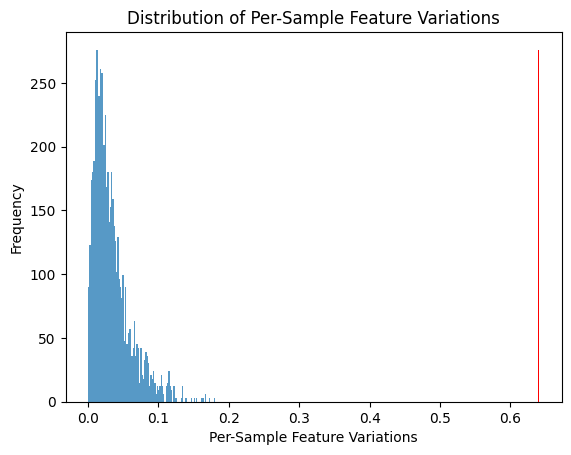

In [37]:
plot_distribution(
    traces,
    bins=100,
    title="Distribution of Per-Sample Feature Variations",
    xlabel="Per-Sample Feature Variations",
    ylabel="Frequency",
)

0.0 1.0
[0.55320746 0.5283336  0.51423186 ... 0.32196587 0.24998744 0.22371627]


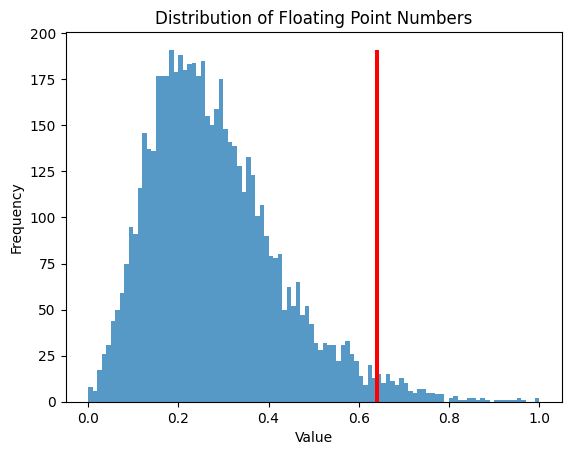

In [38]:
plot_distribution(normalize_values(test_snap_scores), bins=100)

In [39]:
snap_vs_trace = compute_similarity_metrics(normalize_values(test_snap_scores), normalize_values(1 / traces))

0.0 1.0
[0.55320746 0.5283336  0.51423186 ... 0.32196587 0.24998744 0.22371627]
5.5345993 6274.886
[0.01149831 0.01149831 0.01149831 ... 0.0062028  0.0062028  0.0062028 ]


In [40]:
print(snap_vs_trace)

{'pearson_corr': -0.05171026377733146, 'spearman_corr': 0.08201622249042345, 'mse': 0.09646236, 'rmse': 0.3105839, 'cosine_sim': 0.26736027, 'kl_divergence': inf, 'jaccard_sim': 0.0}


In [41]:
def fit_gmm_and_estimate_density(data, n_components=3):
    # Fit a Gaussian Mixture Model to the data
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data)

    # Estimate the density around each vector in the data
    log_prob_density = gmm.score_samples(data)

    return log_prob_density

e_peps = test_e_peps
prob_density = fit_gmm_and_estimate_density(e_peps, n_components=20)
print(len(prob_density), len(e_peps))
print(prob_density)
print(max(prob_density))

2000 2000
[1136.21159609 1090.09425856 1063.39269821 ... 1048.26379318 1117.99949504
 1136.20629159]
1246.1329619887395


In [42]:
def fit_vmf_and_estimate_density(data, n_clusters=3, max_iter=100, tol=1e-3):
    # Fit a von Mises-Fisher Mixture Model to the data
    vmf = VonMisesFisherMixture(n_clusters=n_clusters, max_iter=max_iter, tol=tol)
    vmf.fit(data)

    # Estimate the density around each vector in the data
    # density_estimates = vmf.predict_proba(data)
    # density_estimates = vmf.score(data)
    density_estimates = vmf.log_likelihood(data)

    return density_estimates


def fit_vmf_and_estimate_density_1(data, n_clusters=3, max_iter=100, tol=1e-3):
    m = data.shape[1]


    # Fit a von Mises-Fisher Mixture Model to the data
    vmf = VonMisesFisherMixture(n_clusters=n_clusters, max_iter=max_iter, tol=tol)
    vmf.fit(data)

    # Compute the log of the density estimate for each data point
    log_exp_terms = np.dot(data, vmf.cluster_centers_.T) * vmf.concentrations_
    log_const_terms = (np.log(vmf.concentrations_) * ((m - 1) / 2)) - (
        np.log(2 * np.pi) * (m / 2) + np.log(iv((m - 1) / 2, vmf.concentrations_))
    )
    log_density_estimate = logsumexp(log_const_terms + log_exp_terms, axis=1, b=vmf.weights_)

    # Normalize the log density estimates and convert back to the density estimate
    max_log_density_estimate = np.max(log_density_estimate)
    shifted_log_density_estimate = log_density_estimate - max_log_density_estimate
    sum_exp_shifted_log_density_estimate = np.sum(np.exp(shifted_log_density_estimate))
    normalized_log_density_estimate = shifted_log_density_estimate - np.log(sum_exp_shifted_log_density_estimate)
    density_estimate = np.exp(normalized_log_density_estimate)

    return log_density_estimate


def fit_vmf_and_estimate_density_2(data, p, n_clusters=3, max_iter=100, tol=1e-3):
    m = p.shape[1]

    # Fit a von Mises-Fisher Mixture Model to the training data p
    vmf = VonMisesFisherMixture(n_clusters=n_clusters, max_iter=max_iter, tol=tol)
    vmf.fit(
        p,
    )

    # Compute the log of the density estimate for each data point
    log_exp_terms = np.dot(data, vmf.cluster_centers_.T) * vmf.concentrations_
    log_const_terms = (np.log(vmf.concentrations_) * ((m - 1) / 2)) - (
        np.log(2 * np.pi) * (m / 2) + np.log(iv((m - 1) / 2, vmf.concentrations_))
    )
    log_density_estimate = logsumexp(log_const_terms + log_exp_terms, axis=1, b=vmf.weights_)

    # Normalize the log density estimates and convert back to the density estimate
    max_log_density_estimate = np.max(log_density_estimate)
    shifted_log_density_estimate = log_density_estimate - max_log_density_estimate
    sum_exp_shifted_log_density_estimate = np.sum(np.exp(shifted_log_density_estimate))
    normalized_log_density_estimate = shifted_log_density_estimate - np.log(sum_exp_shifted_log_density_estimate)
    density_estimate = np.exp(normalized_log_density_estimate)

    return log_density_estimate


def normalize_values(values):
    min_val, max_val = min(values), max(values)
    vals = np.array(values)
    normalized_values = (vals - min_val) / (max_val - min_val)
    print(min_val, max_val)
    print(normalized_values)
    return normalized_values

In [43]:
def plot_density_estimates(
    density_estimates,
    title="Density Estimates",
    xlabel="Vector Index",
    ylabel="Density",
):
    n_vectors = len(density_estimates)
    vector_indices = np.arange(n_vectors)

    # Create a bar plot of the density estimates
    plt.bar(vector_indices, density_estimates)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(vector_indices)
    plt.show()

In [44]:
def plot_density_distribution(
    density_estimates,
    bins=None,
    title="Density Distribution",
    xlabel="Density",
    ylabel="Frequency",
):
    # Create a histogram of the density estimates
    plt.hist(density_estimates, bins=bins, alpha=0.75)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.xlim(min(density_estimates), max(density_estimates))
    plt.ylabel(ylabel)
    plt.show()

In [45]:
density_estimates_peps = fit_vmf_and_estimate_density_1(test_e_peps, n_clusters=20)
print(density_estimates_peps)
print(min(density_estimates_peps), max(density_estimates_peps))

[428.57899992 391.36820207 395.3550681  ... 404.66276598 404.36249282
 399.48494011]
358.6488904485235 448.15923617923164


In [46]:
density_estimates_peps = normalize_values(density_estimates_peps)

358.6488904485235 448.15923617923164
[0.7812517  0.36553665 0.41007749 ... 0.51406209 0.51070747 0.45621598]


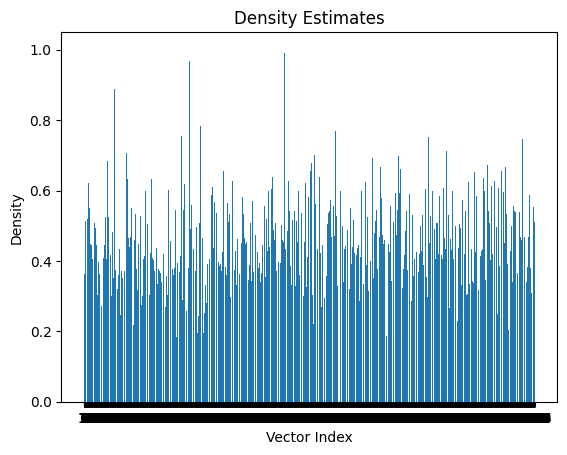

In [47]:
plot_density_estimates(density_estimates_peps)

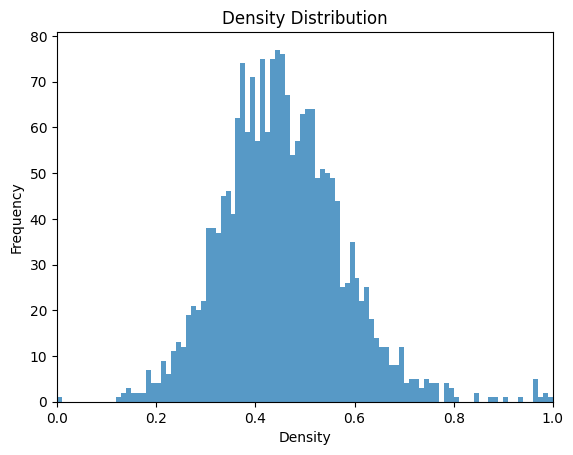

In [48]:
plot_density_distribution(density_estimates_peps, bins=100)

In [49]:
prob_density_specs = fit_vmf_and_estimate_density_2(test_e_specs[::k], p, n_clusters=3)
# if not os.path.exists("outputs"):
#     os.mkdir("outputs")
# prob_density_specs = np.load("outputs/prob_density_specs.npy")[0::k]

In [50]:
density = normalize_values(prob_density_specs)

369.16675708693026 414.7883366535819
[0.34296388 0.34434751 0.34328504 ... 0.47449654 0.50613076 0.53270948]


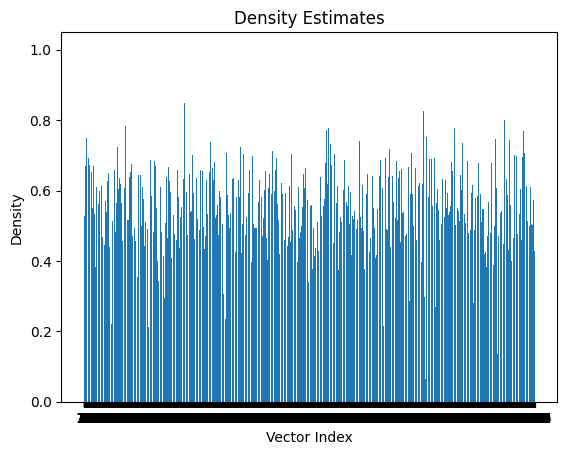

In [51]:
plot_density_estimates(density)

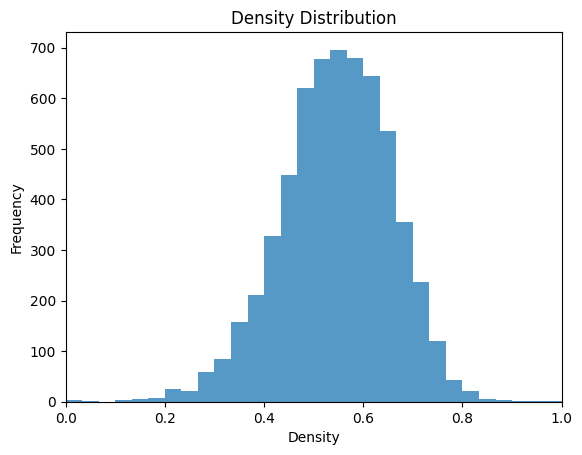

In [52]:
plot_density_distribution(density, bins=30)

In [53]:
snap_vs_density = compute_similarity_metrics(test_snap_scores, prob_density_specs)
print(snap_vs_density)

{'pearson_corr': -0.24022907886623107, 'spearman_corr': -0.2443700844006864, 'mse': 155071.62665752124, 'rmse': 393.7913491400252, 'cosine_sim': 0.885999727622231, 'kl_divergence': 2350508.9248823496, 'jaccard_sim': 0.0}


0.0 1.0
[0.55320746 0.5283336  0.51423186 ... 0.32196587 0.24998744 0.22371627]
369.16675708693026 414.7883366535819
[0.34296388 0.34434751 0.34328504 ... 0.47449654 0.50613076 0.53270948]


/tmp/ipykernel_337498/644690178.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


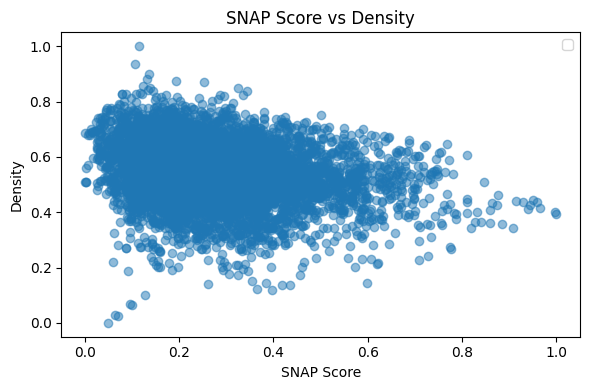

In [54]:
import matplotlib.pyplot as plt

# Assuming ref_scores, score1, score2, score3 are your score arrays
plt.figure(figsize=(6, 4))

# plt.subplot(1, 2, 1)
plt.scatter(
    normalize_values(test_snap_scores),
    normalize_values(prob_density_specs),
    alpha=0.5,
)
plt.xlabel("SNAP Score")
plt.ylabel("Density")
plt.title("SNAP Score vs Density")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.scatter(normalize_values(test_snap_scores), normalize_values(1 - density), c=test_spec_charges[::k], alpha=0.5)
# plt.xlabel('SNAP Score')
# plt.ylabel('1 - Density')
# plt.title('SNAP Score vs Density')

plt.tight_layout()
plt.show()

In [55]:
import numpy as np
from bisect import bisect_left, bisect_right
from scipy.sparse import lil_matrix
from sklearn.metrics.pairwise import cosine_similarity


def find_indices_within_tolerance(precursor_masses, target_mass, tol):
    lower_mass = target_mass - tol
    upper_mass = target_mass + tol

    lower_index = bisect_left(precursor_masses, lower_mass)
    upper_index = bisect_right(precursor_masses, upper_mass)

    return lower_index, upper_index


def spectral_similarity(spec1, spec2):
    mz1 = spec1[0].astype(int)
    mz2 = spec2[0].astype(int)

    intensity1 = spec1[1]
    intensity2 = spec2[1]

    dot_product = 0
    i, j = 0, 0
    while i < len(mz1) and j < len(mz2):
        if mz1[i] == mz2[j]:
            dot_product += intensity1[i] * intensity2[j]
            i += 1
            j += 1
        elif mz1[i] < mz2[j]:
            i += 1
        else:
            j += 1

    norm1 = np.linalg.norm(intensity1)
    norm2 = np.linalg.norm(intensity2)

    if norm1 != 0 and norm2 != 0:
        similarity = dot_product / (norm1 * norm2)
    else:
        similarity = 0

    return similarity


def msms_similarity(specs1, specs2, emb1, emb2, precursors1, precursors2, tol):
    # Initialize results matrix as a sparse matrix
    sim_matrix = lil_matrix((len(specs1), len(specs2)), dtype=np.float32)
    emb_sim_matrix = lil_matrix((len(emb1), len(emb2)), dtype=np.float32)


    # Iterate over all spectra in specs1
    for i in tqdm(range(len(specs1)), desc="Calculating spectral similarity"):
        
        # Find spectra in specs2 within tolerance
        start_index = bisect_left(precursors2, precursors1[i] - tol)
        end_index = bisect_right(precursors2, precursors1[i] + tol)
        for j in range(start_index, end_index):
            # Calculate spectral similarity
            sim_matrix[i, j] = spectral_similarity(specs1[i], specs2[j])

            # Calculate embedding similarity
            emb_sim_matrix[i, j] = cosine_similarity(emb1[i].reshape(1, -1), emb2[j].reshape(1, -1))[0][0]

    print(sim_matrix.shape)
    print(sim_matrix)
    return sim_matrix.tocsr(), emb_sim_matrix.tocsr()


def normalize(values):
    min_val = np.min(values)
    max_val = np.max(values)
    return (values - min_val) / (max_val - min_val)


def embedding_confidence(test_X, train_X, test_Y, train_Y, test_precursors, train_precursors, tol, k):
    num_test = len(test_X)
    consistency = np.zeros(num_test)
    sim_X = np.zeros(num_test)
    sim_Y = np.zeros(num_test)

    # Get the spectral and embedding similarity matrices
    spec_sim_matrix, emb_sim_matrix = msms_similarity(
        test_X, train_X, test_Y, train_Y, test_precursors, train_precursors, tol
    )

    print("Debugging")
    print(spec_sim_matrix)
    print(emb_sim_matrix)

    for i in tqdm(range(num_test), desc="Get top k and calculate confidence"):
        # Get the spectral and embedding similarities for the i-th test example
        spec_similarities = spec_sim_matrix[i].toarray().flatten()
        emb_similarities = emb_sim_matrix[i].toarray().flatten()

        # Get the indices of the top-k most similar examples
        top_k_spec_indices = np.argpartition(spec_similarities, -k)[-k:]
        top_k_emb_indices = np.argpartition(emb_similarities, -k)[-k:]

        # Calculate the mean similarities in the input and embedding spaces
        mean_sim_X = np.mean(spec_similarities[top_k_spec_indices])
        mean_sim_Y = np.mean(emb_similarities[top_k_emb_indices])

        # Calculate the confidence score for the i-th test example
        sim_X[i] = mean_sim_X
        sim_Y[i] = mean_sim_Y
        consistency[i] = np.abs(mean_sim_X - mean_sim_Y)

    return consistency, sim_X, sim_Y

In [56]:
print(min(test_spec_masses))

2000.003655683


In [68]:
# confidence = embedding_confidence(
#     test_np_specs[::k], train_np_specs, test_e_specs[::k], q, test_spec_masses[::k], train_spec_masses[::k], tol=10, k=1
# )

consistency = np.load("/lclhome/mtari008/DeepSNAP/uncertainty_analysis/outputs/consistency.npy")[0::k]
sim_X = np.load("/lclhome/mtari008/DeepSNAP/uncertainty_analysis/outputs/sim_X.npy")[0::k]
sim_Y = np.load("/lclhome/mtari008/DeepSNAP/uncertainty_analysis/outputs/sim_Y.npy")[0::k]

In [69]:
print(len(test_np_specs))

6000


In [70]:
# data, sim_X, sim_Y = confidence
print(sim_Y)
print(k)
# consistency = data
data =  consistency
print(min(data), max(data))
data_sorts = sorted(data, reverse=True)

[0.7388289  0.7475794  0.75055921 ... 0.76184452 0.72359163 0.77573997]
1
0.024830937385559082 0.6524718999862671


In [71]:
sim_X = sim_X[::k]
data = data[::k]

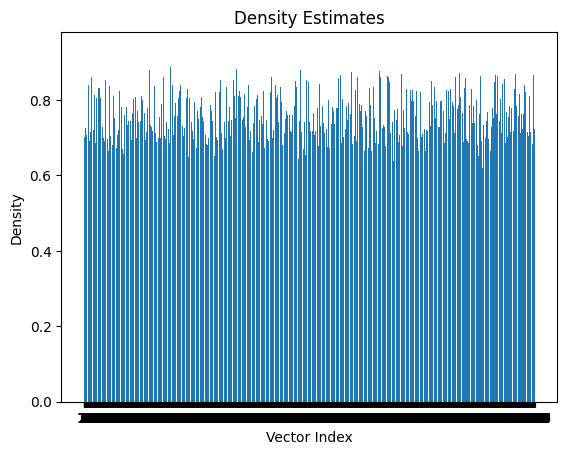

In [72]:
plot_density_estimates(sim_Y)  # Not de"nsity estimates, but confidence estimates

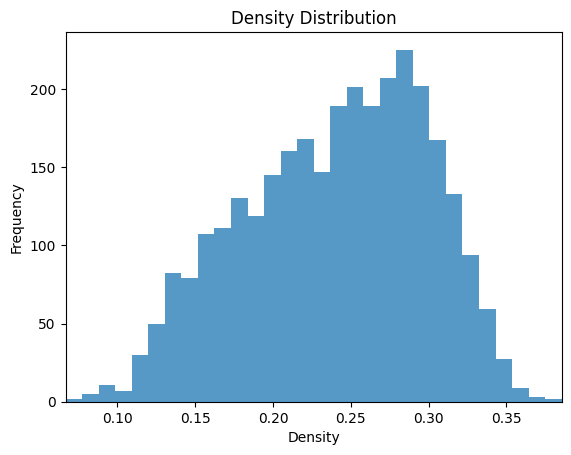

In [73]:
plot_density_distribution(1 - sim_Y, bins=30)  # Not density distribution, but confidence distribution

In [74]:
test_snap_scores = np.array(test_snap_scores)
print(len(sim_X))

3060


In [75]:
# test_snap_scores = test_snap_scores[sim_X != 0]
# sim_Y = sim_Y[sim_X != 0]
# data = data[sim_X != 0]
# sim_X = sim_X[sim_X != 0]

In [76]:
print(len(sim_X))
print(len(consistency))
test_snap_scores_3 = test_snap_scores_3[:len(consistency)]
print(compute_similarity_metrics(test_snap_scores_3, consistency))
print(compute_similarity_metrics(test_snap_scores_3, sim_X))
print(compute_similarity_metrics(test_snap_scores_3, sim_Y))

3060
3060
{'pearson_corr': 0.00814450465217284, 'spearman_corr': 0.01819285555120649, 'mse': 2.459094066294643, 'rmse': 1.568149886424969, 'cosine_sim': 0.9379946973793778, 'kl_divergence': 5358.409320418519, 'jaccard_sim': 0.0}
{'pearson_corr': -0.00610660823107141, 'spearman_corr': -0.016752989799106045, 'mse': 2.2607304432561843, 'rmse': 1.503572560023687, 'cosine_sim': 0.9285111779562176, 'kl_divergence': 4583.4932511632815, 'jaccard_sim': 0.0}
{'pearson_corr': 3.466238076179143e-06, 'spearman_corr': -0.01279623590048393, 'mse': 1.3671074621748904, 'rmse': 1.1692337072522714, 'cosine_sim': 0.9755877210565276, 'kl_divergence': 1859.2308104515346, 'jaccard_sim': 0.0}
